In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import math

In [22]:
df = pd.read_csv('../data/newset/combined_sentiment_stock_TSLA.csv')
df = df.dropna(subset=['Open', 'Close']).copy().reset_index(drop=True)
df['Movement'] = (df['Close'] > df['Open']).astype(int)
df['Return'] = (df['Close'] - df['Open']) / df['Open']
df['Range']  = (df['High'] - df['Low']) / df['Open']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['Return', 'Range'], inplace=True)


In [23]:
up_days = df['Movement'].sum()
down_days = len(df) - up_days
print(f"Total samples after cleaning: {len(df)}")
print(f"Up days: {up_days}, Down days: {down_days} (Up {up_days/len(df):.1%}, Down {down_days/len(df):.1%})")


Total samples after cleaning: 83
Up days: 39, Down days: 44 (Up 47.0%, Down 53.0%)


In [24]:
features = ['posts_per_day', 'avg_sentiment', 'Return', 'Range', 'Volume']
features = [f for f in features if f in df.columns]
if not features:
    raise ValueError("No valid features selected or found in the DataFrame.")

X_all = df[features].astype(float).values
y_all = df['Movement'].values

seq_length = 5
total_sequences = len(df) - seq_length
train_seq_count = int(0.6 * total_sequences)
last_train_label_idx = seq_length + train_seq_count - 1

if last_train_label_idx >= len(X_all):
    train_seq_count = max(0, len(X_all) - seq_length)
    total_sequences = len(X_all) - seq_length
    train_seq_count = int(0.6 * total_sequences)
    last_train_label_idx = seq_length + train_seq_count - 1

scaler = StandardScaler()
scaler.fit(X_all[:last_train_label_idx + 1, :])
X_all_scaled = scaler.transform(X_all)


In [25]:
X_sequences = []
y_sequences = []
for i in range(seq_length, len(df)):
    if i < len(X_all_scaled):
        X_sequences.append(X_all_scaled[i-seq_length:i, :])
        y_sequences.append(y_all[i])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

if len(X_sequences) == 0:
    raise ValueError("No sequences could be created.")

print(f"Sequence shape: {X_sequences.shape}")


Sequence shape: (78, 5, 5)


In [26]:
total_sequences = len(X_sequences)
train_seq_count = int(0.6 * total_sequences)
val_seq_count = int(0.2 * total_sequences)
test_seq_count = total_sequences - train_seq_count - val_seq_count

if train_seq_count == 0 or val_seq_count == 0 or test_seq_count == 0:
    if total_sequences >= 3:
        train_seq_count = max(1, int(0.6 * total_sequences))
        val_seq_count = max(1, int(0.2 * total_sequences))
        test_seq_count = total_sequences - train_seq_count - val_seq_count
        if test_seq_count < 0:
            train_seq_count = int(total_sequences / 3)
            val_seq_count = int(total_sequences / 3)
            test_seq_count = total_sequences - train_seq_count - val_seq_count

X_train = X_sequences[:train_seq_count]
y_train = y_sequences[:train_seq_count]
X_val   = X_sequences[train_seq_count:train_seq_count + val_seq_count]
y_val   = y_sequences[train_seq_count:train_seq_count + val_seq_count]
X_test  = X_sequences[train_seq_count + val_seq_count:]
y_test  = y_sequences[train_seq_count + val_seq_count:]

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")


Train: 46, Val: 15, Test: 17


In [27]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

train_up_count = y_train_t.sum().item()
train_down_count = len(y_train_t) - train_up_count

print(f"Train label distribution: Up={train_up_count}, Down={train_down_count}")

class_weights = [1.0/train_down_count if label == 0 else 1.0/train_up_count for label in y_train_t]
class_weights_t = torch.tensor(class_weights, dtype=torch.float32)

sampler = WeightedRandomSampler(weights=class_weights_t, num_samples=len(class_weights_t), replacement=True)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler, drop_last=False)

val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, drop_last=False)


Train label distribution: Up=20.0, Down=26.0


In [28]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, num_layers=1, dropout=0.4):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                             batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        logit = self.fc(last_out)
        return logit.squeeze(1)

input_dim = X_train.shape[2]
model = LSTMClassifier(input_dim=input_dim)

In [29]:
pos_weight_value = train_down_count / train_up_count if train_up_count > 0 else 1.0
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight_value, dtype=torch.float32))
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

patience = 15
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False
min_delta = 0.001
epochs = 100
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}


In [30]:
print("\nStarting training...")
for epoch in range(1, epochs + 1):
    if early_stop:
        print(f"Early stopping triggered at epoch {epoch-1}")
        break

    model.train()
    epoch_loss = 0.0
    correct = total_samples = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(X_batch)
        preds = (torch.sigmoid(logits) >= 0.5).long()
        correct += (preds == y_batch.long()).sum().item()
        total_samples += len(X_batch)

    train_loss = epoch_loss / total_samples
    train_acc = correct / total_samples

    model.eval()
    val_epoch_loss = 0.0
    val_correct = val_total_samples = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_logits = model(X_val_batch)
            val_batch_loss = criterion(val_logits, y_val_batch)
            val_epoch_loss += val_batch_loss.item() * len(X_val_batch)
            val_preds = (torch.sigmoid(val_logits) >= 0.5).long()
            val_correct += (val_preds == y_val_batch.long()).sum().item()
            val_total_samples += len(X_val_batch)

    val_loss = val_epoch_loss / val_total_samples
    val_acc = val_correct / val_total_samples

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}: train_loss={train_loss:.4f}, train_acc={train_acc:.2f}, val_loss={val_loss:.4f}, val_acc={val_acc:.2f}")

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True



Starting training...
Epoch 001: train_loss=0.7686, train_acc=0.59, val_loss=0.7947, val_acc=0.47
Epoch 010: train_loss=0.6398, train_acc=0.78, val_loss=0.7322, val_acc=0.73
Epoch 020: train_loss=0.3762, train_acc=0.93, val_loss=0.7357, val_acc=0.67
Epoch 030: train_loss=0.3513, train_acc=0.98, val_loss=0.6760, val_acc=0.73
Epoch 040: train_loss=0.2205, train_acc=0.98, val_loss=0.5897, val_acc=0.73
Epoch 050: train_loss=0.0810, train_acc=1.00, val_loss=0.5309, val_acc=0.80
Epoch 060: train_loss=0.0454, train_acc=1.00, val_loss=0.5548, val_acc=0.73
Early stopping triggered at epoch 66


In [31]:
model.eval()
with torch.no_grad():
    test_logits = model(X_test_t)
    test_probs = torch.sigmoid(test_logits).numpy().flatten()
    test_pred_labels = (test_probs >= 0.5).astype(int)

test_acc = accuracy_score(y_test, test_pred_labels)
test_precision = precision_score(y_test, test_pred_labels, zero_division=0)
test_recall = recall_score(y_test, test_pred_labels, zero_division=0)
test_f1 = f1_score(y_test, test_pred_labels, zero_division=0)
try:
    test_auc = roc_auc_score(y_test, test_probs) if len(np.unique(y_test)) > 1 else "N/A"
except ValueError:
    test_auc = "N/A (error calculating AUC)"
cm = confusion_matrix(y_test, test_pred_labels)

print("\n--- Test Set Evaluation ---")
print(f"Accuracy: {test_acc:.2%} | Precision: {test_precision:.2f} | Recall: {test_recall:.2f} | F1: {test_f1:.2f} | AUC: {test_auc}")
print(f"Confusion Matrix:\n{cm}")



--- Test Set Evaluation ---
Accuracy: 47.06% | Precision: 0.50 | Recall: 0.11 | F1: 0.18 | AUC: 0.5
Confusion Matrix:
[[7 1]
 [8 1]]


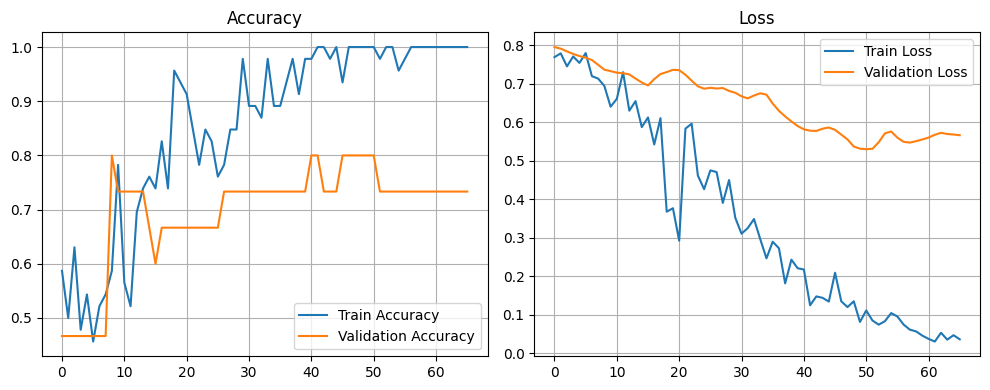

In [32]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


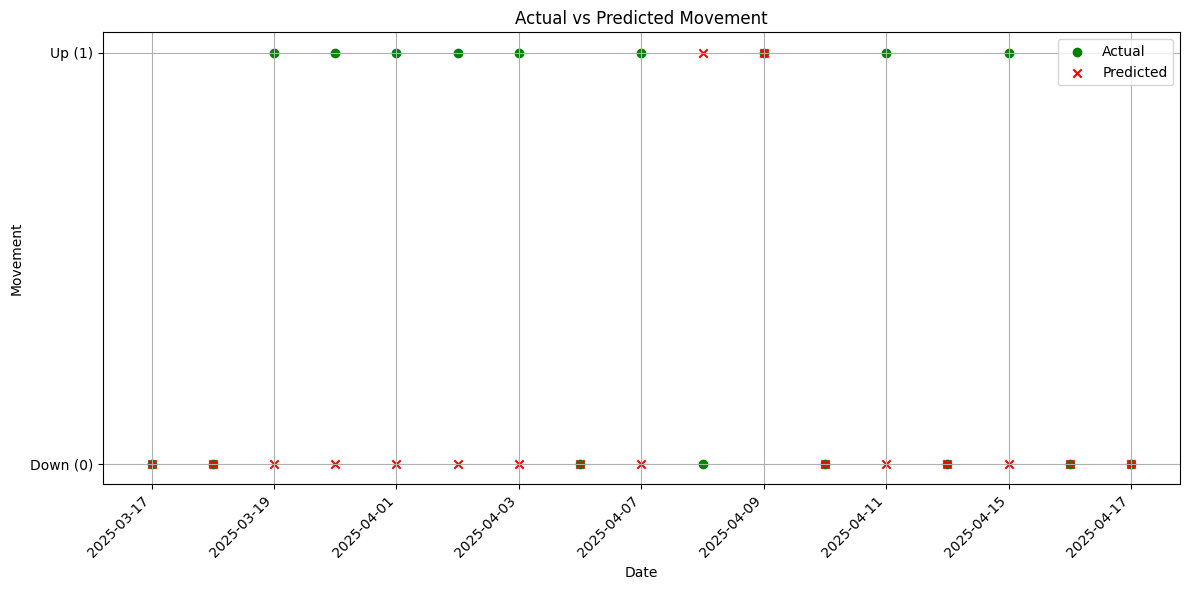

In [33]:
first_test_label_idx_in_df = seq_length + train_seq_count + val_seq_count
test_dates = df['date_only_stock'].iloc[first_test_label_idx_in_df:].reset_index(drop=True)

x = np.arange(len(test_pred_labels))
plt.figure(figsize=(12,6))
plt.scatter(x, y_test, marker='o', color='green', label='Actual')
plt.scatter(x, test_pred_labels, marker='x', color='red', label='Predicted')
plt.xticks(x[::max(1, math.ceil(len(test_dates) / 15))], test_dates[::max(1, math.ceil(len(test_dates) / 15))], rotation=45, ha='right')
plt.yticks([0, 1], ['Down (0)', 'Up (1)'])
plt.xlabel('Date')
plt.ylabel('Movement')
plt.title('Actual vs Predicted Movement')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
